## Questions:
- how many unique question askers are there? Is it just the same people again and again? Does this create a bias? (e.g. there are an awful lot of questions on bees)
- there are lots of funny questions - what percentage of total? Maybe this shows people prefer the less-serious questions? Or are just science room people particularly comedic?
- look at percentage of questions on apocalypse, health, technology - seems people are particularly concered with mortality 
- very few engineering or chemistry questions?
- most physics questions are space or sound
- lots of food / nutrition questions 
- SO MUCH PSYCHOLOGY (is this a Jamal bias though?)


**Note**: every time I print out the dataframe, I have made sure not to include columns including surnames or other sensitive data, hence why you see a lot of 'drop' commands there.

## Import and process dataset

Import the dataset in and do some basic processing so that it's easier to analyse.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud

In [68]:
def dateparse(x):
    if x == 'Pilot':
        x = '14/06/2017'
    return pd.datetime.strptime(x, '%d/%m/%Y')

funnyparse = lambda x: False if x == 'n' else True

qs = pd.read_csv('broken.csv', skiprows=2, parse_dates=['When?'], date_parser=dateparse,
                 converters={'Funny':funnyparse, 'human':funnyparse})

In [69]:
qs.drop(['Name' ,'Other comments', 'Who?', 'who?'], axis=1).head()

,When?,Questions,Answered?,"Will this be a potential talk, blog post, or nothing?",Funny,human,Tags,Unnamed: 10,selected by academic,content type,answered online?,selected for event?,next step?
0,2015-06-01,"""Could machines be conscious?""",y,Event,False,False,"technology, engineering, consciousness",NaN,y,Article or Video,n,y,Jamal does
1,2015-06-01,"""Are we approaching to an ecological collapse?""",n,Event,False,False,"biology, apocalypse, ecology",NaN,y,Video,n,y,NaN
2,2015-06-01,"""Are we losing the war on disease?""",n,Event,False,True,"disease, apocalypse, medicine, biology",NaN,n,NaN,n,n,NaN
3,2015-06-01,"""Is the nature of reality dependent on our obs...",n,Content: Read,False,True,"psychology, philosophy, reality",NaN,n,NaN,n,n,NaN
4,2015-06-01,"""What inventions would we not have without the...",n,Event / Content,False,True,"engineering, space, technology",NaN,n,NaN,n,n,NaN


In [70]:
qs.rename(columns={'When?':'date', 'Will this be a potential talk, blog post, or nothing? ':'output_type', 
                   'Who?':'who', 'Other comments':'comments', 'Name': 'first_name', 'Questions':'questions'}, inplace=True)

qs.drop(['Unnamed: 10', 'who?'], axis=1, inplace=True)

In [71]:
qs.insert(1, 'last_name', None)
for i, r in qs.iterrows():
    if r.last_name is None:
        try:
            names = r['first_name'].split(' ')
            if len(names) > 1:
                qs.set_value(i, 'first_name', names[0])
                qs.set_value(i, 'last_name', ' '.join(names[1:]))
        except AttributeError:
            pass

In [72]:
qs.drop(['last_name', 'comments', 'who'], axis=1).head(10)

,first_name,date,questions,Answered?,output_type,Funny,human,Tags,selected by academic,content type,answered online?,selected for event?,next step?
0,Przemek,2015-06-01,"""Could machines be conscious?""",y,Event,False,False,"technology, engineering, consciousness",y,Article or Video,n,y,Jamal does
1,Przemek,2015-06-01,"""Are we approaching to an ecological collapse?""",n,Event,False,False,"biology, apocalypse, ecology",y,Video,n,y,NaN
2,Philip,2015-06-01,"""Are we losing the war on disease?""",n,Event,False,True,"disease, apocalypse, medicine, biology",n,NaN,n,n,NaN
3,Philip,2015-06-01,"""Is the nature of reality dependent on our obs...",n,Content: Read,False,True,"psychology, philosophy, reality",n,NaN,n,n,NaN
4,Tim,2015-06-01,"""What inventions would we not have without the...",n,Event / Content,False,True,"engineering, space, technology",n,NaN,n,n,NaN
5,Tim,2015-06-01,"""What inventions would we not have without war...",n,Event / Content,False,True,"anthropology, history, technology, engineering",n,NaN,n,n,NaN
6,Tim,2015-06-01,"""How can science / technology make us happier?""",n,Event / Podcast,False,True,"technology, anthropology, neuroscience, psycho...",y,NaN,NaN,y,NaN
7,Andrei,2015-06-01,"""What would the world be like without or with ...",n,Event / Content,False,False,"gravity, physics",y,Article,NaN,NaN,check with Joe if it's good to add to editing ...
8,Abhi,2015-07-04,"""How do mirror neurons work?""",y,Content,False,True,"biology, neuroscience",y,Article,y,n,NaN
9,Reshma,2015-07-04,"""Can a machine identify cancer cell developing...",y,Event,False,True,"cancer, technology, medicine, biology",n,Article or Video,n,y,check with Joe if he wants to do a video on it?


Plot number of questions asked per month. You can see that there are drops around Christmas and Easter, as would be expected.

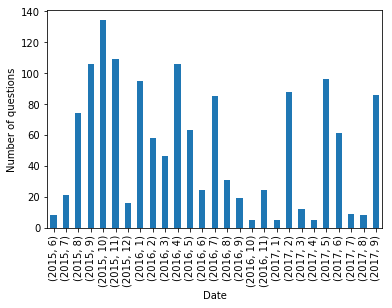

In [73]:
fig = qs[['date']].groupby([qs["date"].dt.year, qs["date"].dt.month]).count().plot(kind="bar", legend=False)
fig.set_xlabel('Date')
fig.set_ylabel('Number of questions')
plt.show()

Rudimentary classification of question types by looking at whether they contain words in the following lists.

In [74]:
# Note: to avoid selection bias, I'm going to need to classify a reasonable fraction of questions. 
# Otherwise e.g. I could just be counting the physics questions.

biology_words = ["ecological", "disease", "nature", "plants", "animals", "animal", "biology", "biological", 
                 "neurons", "cancer", "cell", "diet", "evolution", "human", "life", "zombie", "DNA",
                "species", "drunk", "nutrition", "virus", "drug", "exercise", "blood", "elephant", "bee", "cat"]
physics_words = ["space", "black hole", "star", "universe", "quantum", "physics", "radiation", "light", "moon",
                "mars", "wormhole", "turbulence", "time", "particles", "antimatter", "nuclear", "clock",
                "wavefunction", "electricity", "power", "gravity", "planet", "dimension", "gravitation", "telescope",
                "magnet", "vibrat", "big bang"]
chemistry_words = ["chemicals", "chemical", "metal", "chemistry", "material", "mineral", "fracking"]
psychology_words = ["psychology", "brain", "conscious", "mind", "memory", "memories"]

In [75]:
qs['genre'] = None

for i, r in qs.iterrows():
    # first try looking at the comments 
    
    try:
        comments = r['comments'].lower()
    except AttributeError:
        comments = ''
        
    if "biolog" in comments:
        qs.set_value(i, 'genre', 'biology')
    elif "physics" in comments:
            qs.set_value(i, 'genre', 'physics')
    elif "chemist" in comments:
        qs.set_value(i, 'genre', 'chemistry')
    elif "psycholog" in comments:
        qs.set_value(i, 'genre', 'psychology')    
    else: 
        for w in biology_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'biology')
                break
        for w in physics_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'physics')
                break
        for w in chemistry_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'chemistry')
                break
        for w in psychology_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'psychology')
                break

## Looking at tags and human / funny

Here, I'm going to look at the tags I've allocated to the questions to see which occur most frequently. I've also tagged each question with the properties 'human' and 'funny' - these are either true or false.

In [76]:
def tag_me(df):
    apocalypse = 0
    psychology = 0
    health = 0
    food = 0

    tag = pd.DataFrame(columns=['freq', 'funny', 'human'])

    for i, r in df.iterrows():
        try:
            if 'apocalypse' in r.Tags:
                apocalypse += 1
            if 'psychology' in r.Tags:
                psychology += 1
            if 'health' in r.Tags:
                health += 1
            if 'food' in r.Tags:
                food += 1

            ts = r.Tags.split(', ')
            for w in ts:
                if w[-1] == ' ':
                    w = w[:-1]
                try:
                    tag.set_value(w, 'freq', tag.loc[w]['freq'] + 1)
                except KeyError:
                    tag.loc[w] = 0
                    tag.set_value(w, 'freq', 1)
                if r.Funny:
                    tag.set_value(w, 'funny', tag.loc[w]['funny'] + 1)
                if r.human:
                    tag.set_value(w, 'human', tag.loc[w]['human'] + 1)
        except TypeError:
            pass

    print('apocalypse: \t', apocalypse/len(df), '\tpsychology: \t', psychology/len(df))
    print('health: \t', health/len(df), '\tfood: \t\t', food/len(df))
    tag.sort_values('freq', ascending=False, inplace=True)
    for i, r in tag.iterrows():
        tag.set_value(i, 'funny', r.funny / r.freq)
        tag.set_value(i, 'human', r.human / r.freq)
    return tag

tags = tag_me(qs)

apocalypse: 	 0.027259684361549498 	psychology: 	 0.3012912482065997
health: 	 0.12266857962697274 	food: 		 0.07388809182209469


In [77]:
sum(qs.Funny) / len(qs)

0.23242467718794835

In [78]:
sum(qs.human) / len(qs)

0.75968436154949781

Most common tags: you can see that biology, psychology and physics are the most popular tags. Technology and health also appear a lot - people ask a lot of questions about the future and about the treatment of disease / general health. Ecology pretty much means 'animals' - people quite like asking about these. As an astrophysicist, I'm pleased to see space is much higher than e.g. particle physics :D

In [79]:
tags.head(10)

,freq,funny,human
biology,479,0.263048,0.780793
psychology,420,0.171429,0.938095
physics,259,0.281853,0.409266
technology,203,0.221675,0.91133
health,167,0.0958084,0.994012
ecology,115,0.4,0.365217
food,103,0.291262,0.893204
philosophy,93,0.387097,0.827957
space,91,0.175824,0.428571
neuroscience,87,0.091954,0.988506


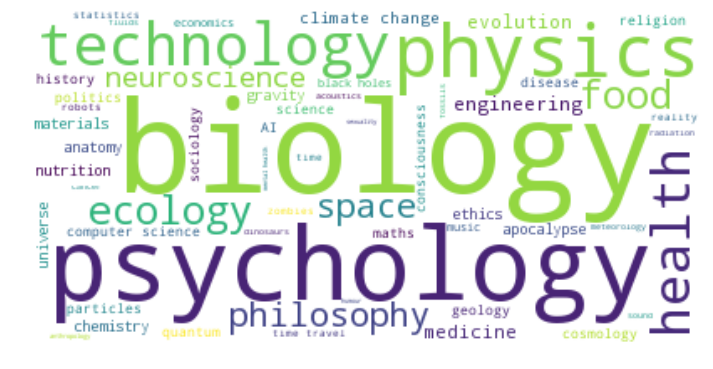

In [153]:
freq_dict = {}
for i, r in tags.iterrows():
    freq_dict[i] = r.freq
    
w = WordCloud(background_color="white").generate_from_frequencies(freq_dict)

plt.figure(figsize=(12, 10))
plt.imshow(w, interpolation="bilinear")
plt.axis("off")
plt.show()

In [80]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

This plot may not make the most sense as human and funny are not two variables we'd necessarily expect to be correlated, but it does show some interesting things. Zombie questions are always funny; cancer questions never are. Over 90% of technology questions are human-related - we're not so interested in whether cats will be conquering Mars any time soon. Climate change is quite a popular topic, and one people take seriously (only 2/62 climate change questions were funny).

In [81]:
msize = lambda x: np.sqrt(np.float(x))

fig = tls.make_subplots(rows=1, cols=1)
x = tags.human
y = tags.funny
text = [i + ': ' + str(tags.loc[i]['freq']) for i in tags.index.values]
t = go.Scatter(x=x, y=y, mode='markers', text=text, 
               marker=dict(size=[3*x**0.5 for x in tags.freq], 
                          color=[3*x**0.5 for x in tags.freq],
                          colorscale='Viridis'))
fig.append_trace(t, 1, 1)

fig['layout']['xaxis1'].update(title='Human')
fig['layout']['yaxis1'].update(title='Funny')
fig['layout'].update(hovermode='closest')
plotly.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



## Finding common question words

Comparing the frequency of query words like 'what', 'where', 'why' should tell us what people want to know and how they ask about things.

In [82]:
qword = dict()
# first find some query words
for i, r in qs.iterrows():
    w = r.questions.split(' ')[0][1:].split("'")[0].split(",")[0].lower()
    qword.setdefault(w, 0)
    qword[w] += 1
# run again using pandas filters so can pick up questions with query words that are not the first word 
# of the question string
for k, i in qword.items():
    if i >= 3:
        qword[k] = len(qs[qs.questions.str.contains(k) | qs.questions.str.contains(k.capitalize())])

# disregard non-query words
dropme = ['in', 'the', 'at', 'is', 'do', 'to']
for d in dropme:
    qword.pop(d)

In [83]:
for k in sorted(qword, key=qword.get, reverse=True):
    if qword[k] < 3:
        break
    print(k, qword[k])

what 323
how 306
we 284
why 245
are 216
if 208
does 180
can 171
could 84
would 80
will 65
when 55
where 37
should 36
did 28
who 22
which 19
has 17


In [84]:
labels = sorted(qword, key=qword.get, reverse=True)[:10]
values = [qword[k] for k in labels]
labels.append('other')
values.append(len(qs) - np.sum(np.array(values)))

trace = go.Pie(labels=labels, values=values, textinfo='label')
layout = go.Layout(title='Most common query words', showlegend=False)
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

## Finding unique questioners & accounting for bias

Looking at whether our set of questions is dominated by the contributions from a small number of people and whether this biases our dataset.

In [85]:
questers = qs[['first_name', 'last_name']].drop_duplicates()
questers.drop('last_name', axis=1).head()

,first_name
0,Przemek
2,Philip
4,Tim
7,Andrei
8,Abhi


In [86]:
len(questers)

401

In [87]:
len(qs) / len(questers)

3.4763092269326683

This demonstrates we indeed have quite a few repeat questioners. Let's look at the most curious:

In [88]:
questers['freq'] = 0
for i, r in questers.iterrows():
    questers.set_value(i, 'freq', len(qs.loc[(qs.first_name == r.first_name) & (qs.last_name == r.last_name)]))

In [89]:
questers.sort_values('freq', ascending=False, inplace=True)
questers.drop('last_name', axis=1).head(10)

,first_name,freq
133,Jamal,85
502,Matt,46
520,Sean,37
1116,Phil,33
125,Olly,33
2,Philip,25
142,John,25
69,Tom,23
371,Matt,21
4,Tim,21


In [90]:
questers['freq'].describe()

count    401.000000
mean       2.738155
std        6.613151
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       85.000000
Name: freq, dtype: float64

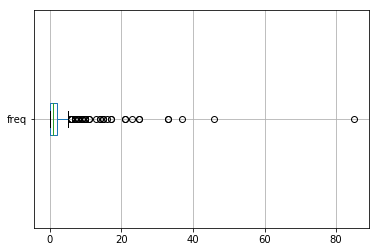

In [91]:
questers.boxplot('freq', vert=False)
plt.show()

In [92]:
trace = go.Box(x=questers.freq, name='All')
layout = go.Layout(title='Number of questions asked per person', showlegend=False)
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

In [93]:
trace = go.Box(x=questers.iloc[15:].freq, name='Except top 15')
layout = go.Layout(title='Number of questions asked per person (excluding 15 most curious)', showlegend=False)
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

Looking at that box plot, we see that indeed our dataset is dominated by contributions from just a few people. Let's see what percentage of the total questions are asked by the top 10 askers:

In [94]:
np.sum(questers.freq.head(10).values) / len(qs)

0.25035868005738882

That's over 25% of the questions which have been asked by just 10 people! This is likely to seriously bias our dataset, as these people are likely to ask questions on similar topics (e.g. Jamal tends to ask about psychology), making our dataset less representative of the general population. To tackle this, let's limit each person to the mean number of questions, rounded up (3). We'll select these randomly from their total questions, and run some analysis again a few times with different random selections to see if we get the same results. 

In [95]:
from random import sample
qs_unbiased = pd.DataFrame(columns=qs.columns)
for i, r in questers.iterrows():
    rs = qs.loc[(qs.first_name == r.first_name) & (qs.last_name == r.last_name)]
    if len(rs) > 3:
        s = sample(range(len(rs)), 3)
        rs = rs.iloc[s]
    qs_unbiased = qs_unbiased.append(rs)

In [96]:
qs_unbiased.drop(['last_name', 'comments', 'who'], axis=1).head(10)

,first_name,date,questions,Answered?,output_type,Funny,human,Tags,selected by academic,content type,answered online?,selected for event?,next step?,genre
447,Jamal,2015-11-26,"""What is the relationship between taste and te...",n,NaN,False,True,"biology, food, psychology",NaN,NaN,NaN,NaN,NaN,None
218,Jamal,2015-10-11,"""Does warming up (e.g. stretching) help exerci...",n,Content: Read (multiple),False,True,"biology, health",NaN,NaN,NaN,NaN,NaN,biology
386,Jamal,2015-11-16,"""Does repression of memories make them stronger?""",n,NaN,False,True,psychology,NaN,NaN,NaN,NaN,NaN,psychology
1047,Matt,2017-02-22,"""Why do pregnant women get morning sickness?""",n,NaN,False,True,"biology, health",NaN,NaN,NaN,NaN,NaN,None
1216,Matt,2017-05-10,"""Are there scientifically proven reasons to im...",n,NaN,False,True,psychology,NaN,NaN,NaN,NaN,NaN,None
961,Matt,2016-08-27,"""If imaginary numbers don't exist, why do they...",n,NaN,False,True,maths,NaN,NaN,NaN,NaN,NaN,None
570,Sean,2016-02-11,"""Is brain surgery harder than rocket science?""",n,Content (Video),True,True,"medicine, engineering, physics",NaN,NaN,NaN,NaN,NaN,psychology
642,Sean,2016-03-21,"""What is love? (Baby don't hurt me, don't hurt...",n,Content (Song),True,True,"psychology, neuroscience, biology",NaN,NaN,NaN,NaN,NaN,None
895,Sean,2016-07-26,"""What is a thing?""",n,NaN,True,False,"philosophy, physics, particles",NaN,NaN,NaN,NaN,NaN,None
1323,Phil,2017-09-13,"""Why are we attracted to the people that we ar...",n,NaN,False,True,"psychology, sexuality",NaN,NaN,NaN,NaN,NaN,None


In [97]:
len(qs_unbiased)

496

In [98]:
tags_u = tag_me(qs_unbiased)

apocalypse: 	 0.018145161290322582 	psychology: 	 0.2701612903225806
health: 	 0.12298387096774194 	food: 		 0.08669354838709678


In [99]:
tags = tag_me(qs)

apocalypse: 	 0.027259684361549498 	psychology: 	 0.3012912482065997
health: 	 0.12266857962697274 	food: 		 0.07388809182209469


In [100]:
tags_u.head(10)

,freq,funny,human
biology,167,0.305389,0.808383
psychology,134,0.141791,0.962687
physics,101,0.29703,0.534653
technology,80,0.2125,0.925
health,59,0.0677966,1
ecology,44,0.409091,0.431818
food,43,0.232558,0.883721
neuroscience,35,0.0857143,1
space,31,0.16129,0.612903
engineering,31,0.258065,0.677419


In [101]:
tags.head(10)

,freq,funny,human
biology,479,0.263048,0.780793
psychology,420,0.171429,0.938095
physics,259,0.281853,0.409266
technology,203,0.221675,0.91133
health,167,0.0958084,0.994012
ecology,115,0.4,0.365217
food,103,0.291262,0.893204
philosophy,93,0.387097,0.827957
space,91,0.175824,0.428571
neuroscience,87,0.091954,0.988506


In [102]:
for i, t in tags_u.head(10).iterrows():
    print(i, '\t', t.freq / len(qs_unbiased))

biology 	 0.33669354838709675
psychology 	 0.2701612903225806
physics 	 0.20362903225806453
technology 	 0.16129032258064516
health 	 0.11895161290322581
ecology 	 0.08870967741935484
food 	 0.08669354838709678
neuroscience 	 0.07056451612903226
space 	 0.0625
engineering 	 0.0625


In [103]:
for i, t in tags.head(10).iterrows():
    print(i, '\t', t.freq / len(qs))

biology 	 0.3436154949784792
psychology 	 0.3012912482065997
physics 	 0.18579626972740315
technology 	 0.14562410329985653
health 	 0.11979913916786226
ecology 	 0.0824964131994261
food 	 0.07388809182209469
philosophy 	 0.0667144906743185
space 	 0.06527977044476327
neuroscience 	 0.062410329985652796


This is actually pretty encouraging: the top 10 most popular tags are more or less the same, as are the percentages with which they occur and their funnyness / humanity. This suggests that although our dataset may be dominated by the contributions from a relatively small number of people, their contributions are largely representative of the total population and do not appear to bias the results significantly. We can therefore continue our analysis with the complete dataset. 

## Physics only

Above analysis but only on physics questions

In [113]:
def search_tags(tag_word):
    # return questions that contain tag word
    return qs[(qs.Tags.str.contains(tag_word)) & (qs.Tags.str.contains(tag_word) == qs.Tags.str.contains(tag_word))]

In [114]:
physics_qs = search_tags('physics')

In [116]:
physics_tags = tag_me(physics_qs)

apocalypse: 	 0.011583011583011582 	psychology: 	 0.04247104247104247
health: 	 0.0 	food: 		 0.019305019305019305


In [151]:
physics_tags.head(10)

,freq,funny,human
physics,259,0.281853,0.409266
space,71,0.140845,0.323944
gravity,46,0.173913,0.434783
technology,42,0.428571,0.833333
universe,34,0.176471,0.176471
engineering,29,0.413793,0.62069
cosmology,23,0.130435,0.130435
particles,22,0.227273,0.227273
biology,20,0.3,0.7
quantum,19,0.157895,0.210526


In [155]:
freq_dict = {}
for i, r in physics_tags.iterrows():
    if i == 'physics':
        continue
    freq_dict[i] = r.freq

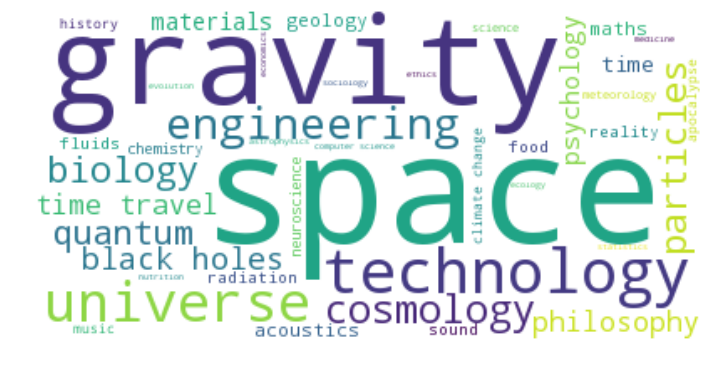

In [157]:
w = WordCloud(background_color="white").generate_from_frequencies(freq_dict)

plt.figure(figsize=(12, 10))
plt.imshow(w, interpolation="bilinear")
plt.axis("off")
plt.show()

In [117]:
msize = lambda x: np.sqrt(np.float(x))

fig = tls.make_subplots(rows=1, cols=1)
x = physics_tags.human
y = physics_tags.funny
text = [i + ': ' + str(physics_tags.loc[i]['freq']) for i in physics_tags.index.values]
t = go.Scatter(x=x, y=y, mode='markers', text=text, 
               marker=dict(size=[3*x**0.5 for x in physics_tags.freq], 
                          color=[3*x**0.5 for x in physics_tags.freq],
                          colorscale='Viridis'))
fig.append_trace(t, 1, 1)

fig['layout']['xaxis1'].update(title='Human')
fig['layout']['yaxis1'].update(title='Funny')
fig['layout'].update(hovermode='closest')
plotly.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



## Looking at output

In [104]:
qs.output_type

0                               Event
1                               Event
2                               Event
3                       Content: Read
4                     Event / Content
5                     Event / Content
6                     Event / Podcast
7                     Event / Content
8                             Content
9                               Event
10                              Event
11           Content: Read (multiple)
12           Content: Read (multiple)
13                              Event
14                              Event
15                            Content
16                  Content (Podcast)
17           Content: Read (multiple)
18                              Event
19                              Event
20                              Event
21                            Content
22                              Event
23                              Event
24                   Content: Podcast
25                  Event (Podcast?)^
26          

In [105]:
qs.output_type.describe()

count             480
unique             58
top       Event: Read
freq              102
Name: output_type, dtype: object

In [106]:
output_types = {'event':0, 'podcast':0, 'content':0, 'infographic':0, 'read':0}

for k, _ in output_types.items():
    output_types[k] = len(qs[qs.output_type.str.contains(k) | qs.output_type.str.contains(k.capitalize())])

In [107]:
for k in sorted(output_types, key=output_types.get, reverse=True):
    print(k, '   \t', output_types[k])

event    	 250
content    	 224
read    	 223
podcast    	 70
infographic    	 11


Note: doesn't look like there was much consistancy with the 'content' label, so not sure how useful this will be.

In [108]:
# search tags

tag_word = 'space'

qs[(qs.Tags.str.contains(tag_word)) & (qs.Tags.str.contains(tag_word) == qs.Tags.str.contains(tag_word))].questions.values

array(['"What inventions would we not have without the space industry?"',
       '"Will the Big Bang Theory be replaced in the near future?"',
       '"Do the current laws of physics support having the whole universe in a single point?"',
       '"What happens to objects inside the event horizon of a black hole?"',
       '"Where is the best place to look for other life in our solar system if anywhere?"',
       '"How can we deal with space debris?"',
       '"What is at the bottom of a Black Hole?"',
       '"Is the water on Mars drinkable? How salty is the water on Mars?"',
       '"How many stars are there?"',
       '"Can I start by saying I am not a physicist and do not understand any of the mathematics that under pins current theory. \nThere\'s a couple of things I hope someone can help me with, and a couple of theories of my own. \nFirstly, if the vast majority of the universe is made of dark matter then does dark matter co-exist alongside visible matter? And if so, is it possib

In [110]:
tags.index

Index(['biology', 'psychology', 'physics', 'technology', 'health', 'ecology',
       'food', 'philosophy', 'space', 'neuroscience', 'engineering',
       'evolution', 'medicine', 'climate change', 'gravity', 'ethics',
       'chemistry', 'anatomy', 'nutrition', 'universe', 'materials',
       'apocalypse', 'sociology', 'maths', 'science', 'disease', 'politics',
       'consciousness', 'cosmology', 'AI', 'geology', 'particles',
       'computer science', 'religion', 'quantum', 'history', 'music',
       'black holes', 'economics', 'reality', 'time travel', 'time', 'robots',
       'statistics', 'zombies', 'cancer', 'meteorology', 'radiation',
       'fossils', 'sound', 'acoustics', 'dinosaurs', 'fluids', 'anthropology',
       'mental health', 'humour', 'sexuality', 'human factors', 'biochemistry',
       'simulations', 'art', 'phlosophy', 'language', 'perception', 'sports',
       'personality', 'spirituality', 'astrophysics', 'na', 'law'],
      dtype='object')

In [111]:
# serach questions

tag_word = 'light'

qs[(qs.questions.str.contains(tag_word)) & (qs.questions.str.contains(tag_word) == qs.questions.str.contains(tag_word))].questions.values


array([ '"What would happen if you submerged under water a light saber assuming it\'s got infinite power?"',
       '"Why do flashing lights cause seizures?"',
       '"Why is the superposition of sound and light waves perceived differently?"',
       '"And how can nutritional medicine shed light on cancer, cardiovascular diseases and anxiety and depression?"',
       '"How can the initial expansion of the universe (inflation) be faster than the speed of light? (Is this because space-time is compressed & convoluted allowing time overlap?)"',
       '"Can I start by saying I am not a physicist and do not understand any of the mathematics that under pins current theory. \nThere\'s a couple of things I hope someone can help me with, and a couple of theories of my own. \nFirstly, if the vast majority of the universe is made of dark matter then does dark matter co-exist alongside visible matter? And if so, is it possible that gravity is an effect caused soley by the dark element and not vis

In [ ]:
import feedparser
import string
import urllib

In [15]:
youtube_rss_url = "https://www.youtube.com/feeds/videos.xml?channel_id=UC_ELhypSb_rbDylFgLVqSwg"

feed = feedparser.parse(youtube_rss_url)

In [ ]:
feed

In [ ]:
for i in feed['items']:
    print(i['yt_videoid'])

In [ ]:
translator = str.maketrans('', '', string.punctuation)
space_translator = str.maketrans(' ', '-')
folder_location = '/home/alice/Dropbox/sr-website-mockups/_posts/'
for i in feed['items']:
    youtube = i['yt_videoid']
    published = i['published'][:10] + ' ' + i['published'][11:19] + ' ' + i['published'][19:]
    author = i['author']
    title = i['title']
    
    print(title)
    
    stripped_title = title.translate(translator).translate(space_translator).lower()
    
    if 'podcast' not in title:
        file_name = folder_location + 'watch/' + published[:10] + '-' + stripped_title + '.md'
    else:
        stripped_title = stripped_title[16:]
        file_name = folder_location + 'listen/' + published[:10] + '-' + stripped_title + '.md'
    print(file_name)
    f = open(file_name, 'w')
    
    f.write('---')
    f.write('\nyoutube: ' + youtube)
    f.write('\npublished: ' + published)
    f.write('\nauthor: ' + author)
    f.write('\ntitle: ' + title.replace(":", "&#58;").replace('"', ''))
    f.write('\n---')
    f.close()